Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


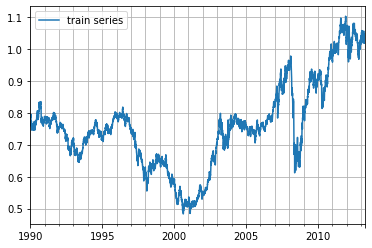

1990-01-01    0.7855
Freq: B, dtype: float32


KeyboardInterrupt: 

In [9]:
#
# Initialization
#

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

print(f"Available datasets: {list(dataset_recipes.keys())}")
# dataset = get_dataset("m4_hourly", regenerate=False)
dataset = get_dataset("exchange_rate", regenerate=False)

entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

print(train_series.head(1))
print(train_series.tail(1))
print(train_series.describe())

entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [6]:
#
# Setup utils
#

print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 30
Recommended prediction horizon: 30
Frequency of the time series: 1B


In [ ]:
#
# Parse dataset
#

from data_processing.parse import Parse

PARSE = Parse(LOGGER)

dataset_dir_path = local_artifact_dir / "datasets"

# Creates train and test dataset CSVs
PARSE.split_train_test_dataset(dataset_dir_path)

In [ ]:
#
# Setup local/aws environment. If aws, upload the datasets to S3
#

from data_processing.aws_handler import AWSHandler
from sagemaker import LocalSession

AWS_HANDLER = AWSHandler(LOGGER, config.MODEL_ID)

sagemaker_session = None

model_output_dir_path = local_artifact_dir / config.MODEL_ID / "models"
model_output_dir_path.mkdir(parents=True, exist_ok=True)

if IS_LOCAL:
    LOGGER.log("Notebook is set to local mode, not uploading to S3")

    dataset_dir_uri = f"file://{dataset_dir_path}"
    model_output_dir_uri = f"file://{model_output_dir_path}"

    sagemaker_session = LocalSession()
    sagemaker_session.config = {
        'local': {
            'local_code': True,
            'container_root': str(model_output_dir_path)
        }
    }
else:
    sagemaker_session = AWS_HANDLER.sagemaker_session

    AWS_HANDLER.upload_train_datasets(dataset_dir_path)
    dataset_dir_uri = AWS_HANDLER.s3_dataset_dir_uri

    model_output_dir_uri = AWS_HANDLER.s3_model_output_uri

LOGGER.log(f"Model output dir is [{model_output_dir_uri}]")

In [ ]:
#
# Configure sagemaker and estimator
#

from ml.train import Train

TRAIN = Train(LOGGER)

if IS_LOCAL:
    train_kwargs = {}
else:
    train_kwargs = {
        # 'checkpoint_s3_uri': model_output_dir_uri,
        'output_path': model_output_dir_uri,
        'code_location': model_output_dir_uri,
        'use_spot_instances': True,
        'max_wait': 18 * 60 * 60, # 18 hours
        'max_run': 18 * 60 * 60, # 18 hours
    }

estimator = TRAIN.create_model(config.SM_ROLE, INSTANCE_TYPE, sagemaker_session, train_kwargs)
TRAIN.fit_model(estimator, dataset_dir_uri)

In [ ]:
#
# Load model
#

import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
from gluonts.model.predictor import Predictor

if IS_LOCAL:
    # model_output_dir_path is basically the same path as it was before, though sagemaker appends a random temp
    # directory to the path. The path from TRAIN includes that random temp directory
    model_dir_path = TRAIN.model_data_path.parent.parent / "model"
    # model_dir_path = local_artifact_dir / "local_cli" / "model"
else:
    model_dir_path = AWS_HANDLER.download_model_from_s3(str(TRAIN.model_data_path), local_artifact_dir)

LOGGER.log(f"Model dir is [{model_dir_path}]")
predictor = Predictor.deserialize(model_dir_path)
LOGGER.log(f"Predictor metadata [{predictor.__dict__}]")


def plot_prob_forecasts(ts_list, forecast_list, plot_length=100):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        prediction_intervals = (50.0, 90.0)
        legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        ax = target[-plot_length:].plot(figsize=(10, 7), linewidth=2)
        forecast.plot(prediction_intervals=prediction_intervals, color='g')
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.show()
    
def plot_prob_forecasts_multi(ts_list, forecast_list, plot_length=100):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        for i in range(4):
            prediction_intervals = (50.0, 90.0)
            legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
            fig, ax = plt.subplots(1, 1, figsize=(10, 7))
            target[i][-plot_length:].plot(ax=ax)  # plot the time series
            forecast.copy_dim(i).plot(prediction_intervals=prediction_intervals, color='g')
            plt.grid(which="both")
            plt.legend(legend, loc="upper left")
            plt.show()

In [ ]:
#
# Define test data and make a prediction
#

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset, FileDataset
from utils.splitter import DateSplitter
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.stat import calculate_dataset_statistics

# test_file_dataset = FileDataset(path=(dataset_dir_path / config.TEST_DATASET_FILENAME).parent, freq="min")
test_file_dataset = FileDataset(path=(dataset_dir_path / config.TEST_DATASET_FILENAME).parent, freq="5min")

# pd.Timedelta(config.HYPER_PARAMETERS["prediction_length"], unit="5min")
# for data in iter(test_file_dataset):
#     data.start.freqstr = "min"

test_datasets = []
test_dates = ["2020-11-20 12:50:00", "2021-01-20 15:55:00", "2021-01-20 17:10:00"]
for idx, date in enumerate(test_dates):
    # 1) Get splice of dataset for different dates with ample history
    splitter = DateSplitter(
        prediction_length=-config.HYPER_PARAMETERS["prediction_length"],
        split_date=date,
        max_history=config.HYPER_PARAMETERS["past_length"]
        # max_history=config.HYPER_PARAMETERS["past_length"] + config.HYPER_PARAMETERS["prediction_length"]
    )
    (_, train_dataset), (_, test_dataset) = splitter.split(test_file_dataset)

    # # 2) Remove other time-series as we only want to predict
    # for data in iter(test_dataset):
    #     if data['item_id'] == "close":
    #         test_dataset = ListDataset([{
    #             FieldName.START: data[FieldName.START],
    #             FieldName.TARGET: data[FieldName.TARGET],
    #             FieldName.FEAT_STATIC_CAT: data[FieldName.FEAT_STATIC_CAT],
    #             FieldName.ITEM_ID: data[FieldName.ITEM_ID],
    #         }], freq=config.DATASET_FREQ)
    #         break

    LOGGER.log(f"Test dataset [{idx}] stats: {calculate_dataset_statistics(test_dataset)}")
    test_datasets.append(test_dataset)

In [ ]:
#
# Evaluate and visualize the prediction
#
import json

from gluonts.evaluation import Evaluator, MultivariateEvaluator

for test_dataset in test_datasets:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    forecast_entry = forecasts[0]
    tss = list(ts_it)

    # LOGGER.log(f"Number of sample paths: {forecast_entry.num_samples}")
    # LOGGER.log(f"Dimension of samples: {forecast_entry.samples.shape}")
    # LOGGER.log(f"Start date of the forecast window: {forecast_entry.start_date}")
    # LOGGER.log(f"Frequency of the time series: {forecast_entry.freq}")

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_dataset))

    LOGGER.log(json.dumps(agg_metrics, indent=4))
    item_metrics.head()

    plot_prob_forecasts(tss, forecasts)

In [ ]:
#
# NOTE: FURTHER CELLS ARE COMPATIBLE WITH AWS SAGEMAKER ONLY, LOCAL MODE WILL NOT WORK
# Hyperparameter tune the model
#

from ml.tune import Tune

TUNE = Tune(UTILS, LOGGER)

train_dataset_uri = f"{dataset_dir_uri}/{config.TRAIN_DATASET_FILENAME}"
test_dataset_uri = f"{dataset_dir_uri}/{config.TEST_DATASET_FILENAME}"

# Note: Feel free to tune the tuner, i.e. update max number of jobs and hyperparameters. Default is 10 jobs, but you
# may want to change this as you refine the model. Additionally, if you find the best model has a parameter at the
# end of the range you gave it, then you should look to move that range to determine if the model performs better
# along that vector
tuner = TUNE.create_tuner(estimator)
TUNE.fit_tuner(tuner, dataset_dir_uri)

In [ ]:
#
# Get updates for Hyperparameter tune job. Ensure this is completed before going to the next cell
#

TUNE.get_tune_job_update()

In [ ]:
#
# Evaluate the metrics of the tune job
#

TUNE.report_job_analytics()
